# Import Packages

In [78]:
import os

import numpy as np
import torch
import seaborn as sns

import qmf

# Set Output Directory

In [79]:
image = qmf.read_image("/scratch/Dropbox/research/projects/qmf/data/kodak/kodim23.png")
save_dir = "./kodim23"
prefix = "kodim23"

# Load and Visualize Image

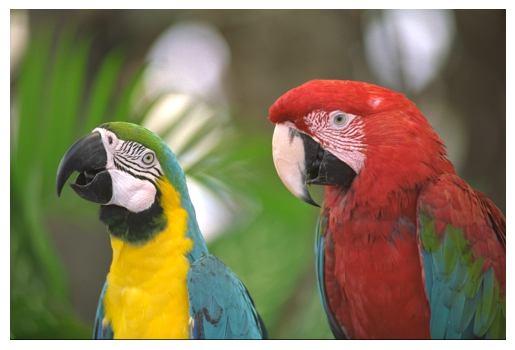

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [80]:
qmf.vis_image(image, save_dir=save_dir, prefix=prefix, format="pdf")

# Calculate Compression metrics

In [ ]:
results = []

# JPEG
for quality in range(0, 30, 1):
    params = {"quality": quality}
    config = {"data": prefix, "method": "JPEG", **params}
    log = qmf.eval_compression(
        image,
        qmf.pil_encode,
        qmf.pil_decode,
        reconstruct=True,
        format="JPEG",
        **params,
    )
    results.append({**config, **log})

# SVD
for quality in np.linspace(0.0, 4, 30):
    params = {
        "color_space": "RGB",
        "quality": quality,
        "patch": True,
        "patch_size": (8, 8),
    }
    config = {"data": prefix, "method": "SVD", **params}
    log = qmf.eval_compression(
        image, qmf.svd_encode, qmf.svd_decode, reconstruct=True, **params
    )
    results.append({**config, **log})


# QMF
for quality in np.linspace(0, 25, 30):
    params = {
        "color_space": "YCbCr",
        "scale_factor": (0.5, 0.5),
        "quality": quality,
        "patch": True,
        "patch_size": (8, 8),
        "bounds": (-16, 15),
        "dtype": torch.int8,
        "num_iters": 10,
        "verbose": False,
    }
    config = {"data": prefix, "method": "QMF", **params}
    log = qmf.eval_compression(
        image, qmf.qmf_encode, qmf.qmf_decode, reconstruct=True, **params
    )
    results.append({**config, **log})

# Plot Metrics vs Bit Rate

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='bit rate (bpp)', ylabel='SSIM'>)

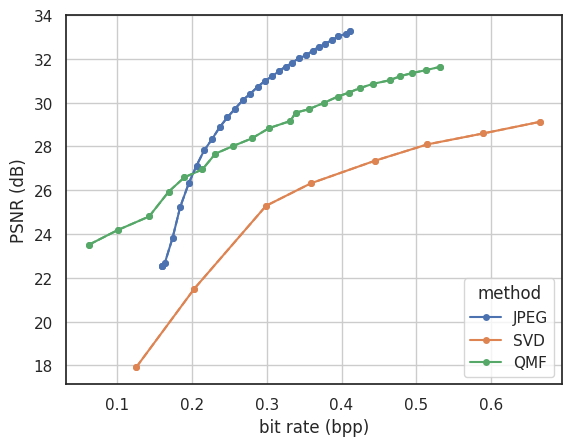

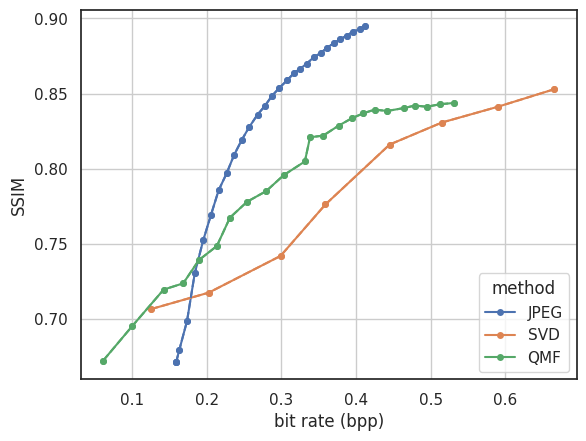

In [ ]:
sns.set_theme(style="white")
plot = qmf.Plot(results, columns=("data", "method", "bit rate (bpp)", "PSNR (dB)"))
plot.plot(x="bit rate (bpp)", y="PSNR (dB)", groupby="method", errorbar=None)

plot = qmf.Plot(results, columns=("data", "method", "bit rate (bpp)", "SSIM"))
plot.plot(x="bit rate (bpp)", y="SSIM", groupby="method", errorbar=None)

# Make Qualitative Comparisons

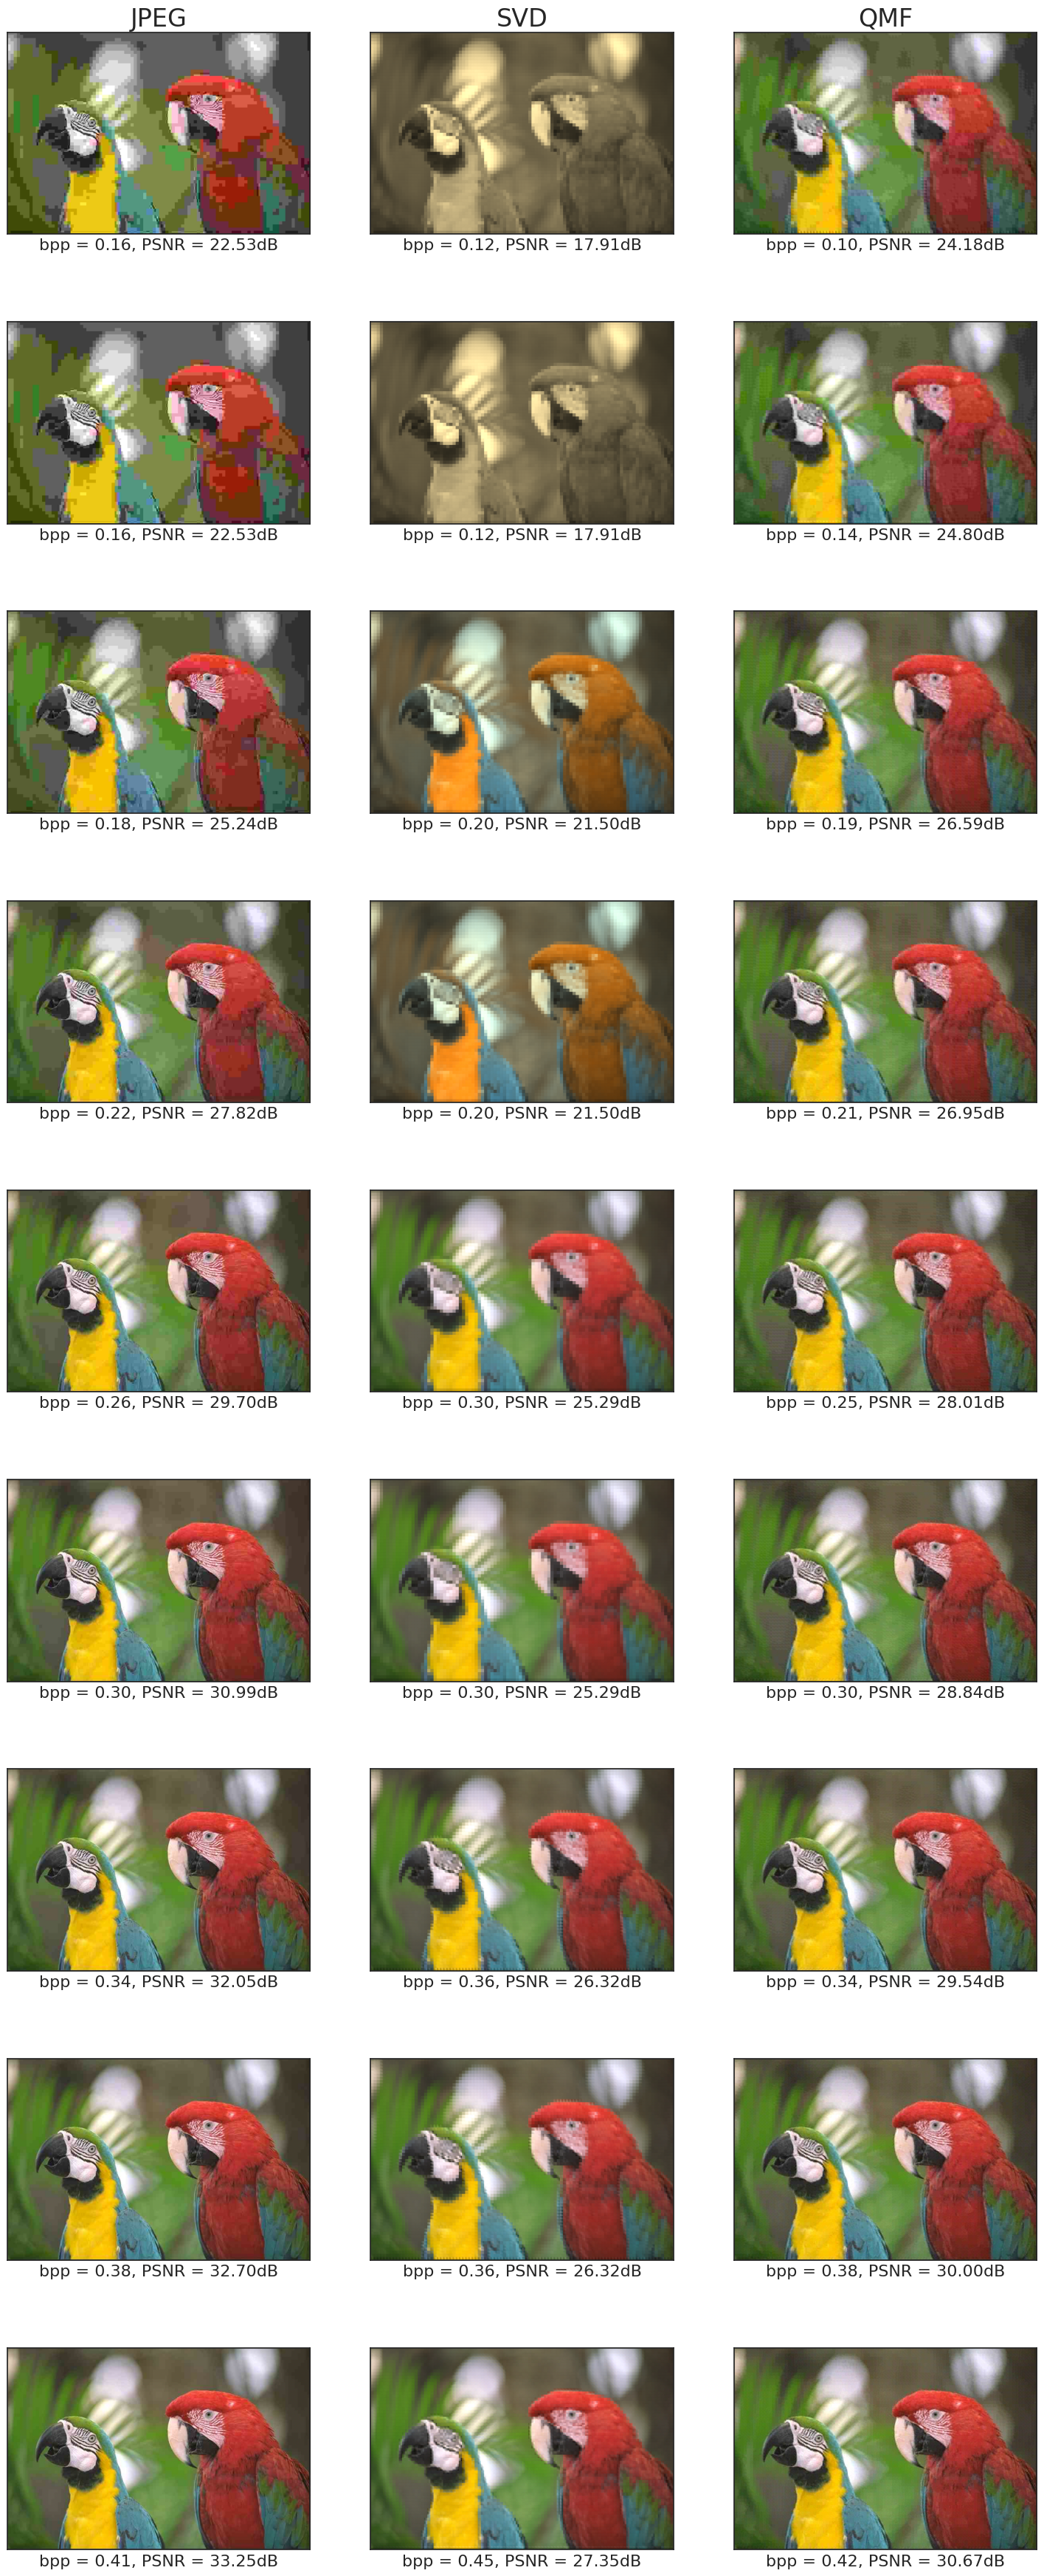

In [ ]:
bpps = np.arange(.1,.46, .04)
fig, axs = qmf.vis_collage(results, bpps=bpps, save_dir=save_dir, prefix=prefix, format="pdf")

# Save Results

In [ ]:
selcted_results = [
    {k: v for k, v in dc.items() if k != "reconstructed"} for dc in results
]
qmf.save_config(selcted_results, save_dir=save_dir, prefix=prefix)